# Testing regularization of likelihood functions

In [1]:
%pylab inline
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"


Populating the interactive namespace from numpy and matplotlib


In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

In [5]:
import tensorflow as tf
import tensorflow.contrib.slim as slim
from tensorflow.contrib.slim import add_arg_scope
import tensorflow_hub as hub


## Creating the forward model

In [28]:
ndim = 2
batch_size = 10000
means = np.array([0., 1.]).astype('float32')
stddevs = np.array([1., 2.]).astype('float32')

tf.reset_default_graph()

def module_fn():
    '''Define network here'''
    x = tf.placeholder(tf.float32, shape=[None, ndim], name='input')
    # This is the linear operator
    A = tf.constant(randn(2,2), dtype=tf.float32) / 2.

    # Defining the forward model
    l = tf.reduce_sum(tf.matmul(x, A), axis=1)
    p = tfd.Poisson(log_rate=l)
    y = tf.reshape(p.sample(), (-1,))

    hub.add_signature(inputs={'input':x}, 
                          outputs={'sample':y, 'lograte':l, 'transform':A})

    
#####                                                                                                                                                                                                                                                                                     

spec = hub.create_module_spec(module_fn)
module = hub.Module(spec, trainable=True)

# Defining probabilistic forward model
prior = tfd.Normal(loc=means, scale=stddevs)
x = prior.sample(batch_size)
l = module({'input':x}, as_dict=True)['lograte']
y = module({'input':x}, as_dict=True)['sample']
A = module({'input':x}, as_dict=True)['transform']


sess = tf.Session()
sess.run(tf.global_variables_initializer())
sx, sy, sl, AA = sess.run([x, y, l, A])




INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [26]:
%%bash
ls modules/
# rm -r modules/fwdmodel/

densemodule


In [29]:
# module.export('./modules/fwdmodel', sess)


INFO:tensorflow:Exported TF-Hub module to: ./modules/fwdmodel


/home/chmodi/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6510: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


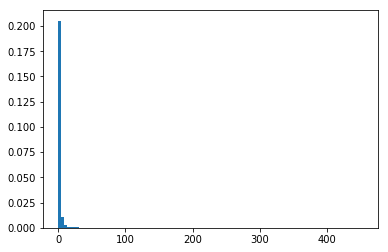

In [32]:
plt.hist(sy, bins=100, normed=True)
plt.show()

In [33]:
sl.max(), sy.max()

(6.085203, 452.0)

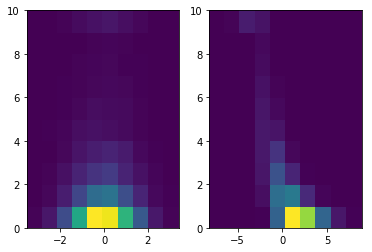

In [34]:
subplot(121)
# hist2d(sx[:,0], sy);
hist2d(sx[:,0], clip(sy.flatten(),0,10));
subplot(122)
# hist2d(sx[:,1], sy);
hist2d(sx[:,1], clip(sy.flatten(),0,10));

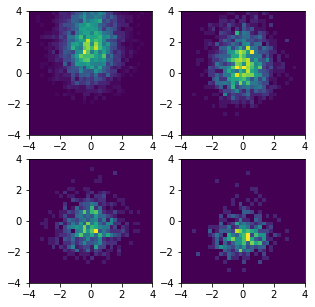

In [35]:
# Have a look at the posterior on x for a given outcome y
figure(figsize=(5,5))
for i in range(4):
    subplot(2,2,i+1)
    m = (sy == i)
    hist2d(sx[:,0][m], sx[:,1][m],32,range=[[-4,4],[-4,4]],normed=True);gca().set_aspect('equal');

In [36]:
# Now, let's try to train a neural network to model the likelihood function

# Module

Train a neural network in a module 

In [37]:
tf.reset_default_graph()


def module_fn():
    '''Define network here'''
    x = tf.placeholder(tf.float32, shape=[None, ndim], name='input')
    y = tf.placeholder(tf.float32, shape=[None], name='output')

    net = tf.layers.dense(x,1024, activation=tf.nn.leaky_relu)
    net = tf.layers.dense(net,512, activation=tf.nn.leaky_relu)
    net = tf.layers.dense(net,1)
#     net = tf.nn.softplus(net, name='lograte')
    out_prob = tfd.Poisson(log_rate=net, name='out_prob')
    loglik = out_prob.log_prob(tf.expand_dims(y, axis=-1))
    sample = out_prob.sample(name='prediction')
    #
    # 
    inputs = dict(input=x, label=y)
    outputs = dict(default=net, loglik=loglik, prediction=sample)
    hub.add_signature(inputs={'features':x, 'labels':y}, 
                          outputs={'sample':sample, 'loglikelihood':loglik, 'lograte':net})
    
#####                                                                                                                                                                                                                                                                                     

spec = hub.create_module_spec(module_fn)
module = hub.Module(spec, trainable=True)

xx = tf.placeholder(tf.float32, shape=[None, ndim], name='input')
lograte = module({'features':xx, 'labels':sy}, as_dict=True)['lograte']
loglik = module({'features':xx, 'labels':sy}, as_dict=True)['loglikelihood']
sample = module({'features':xx, 'labels':sy}, as_dict=True)['sample']
loss = -tf.reduce_mean(loglik)


optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train_op = optimizer.minimize(loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())
losses =[]

lrate0 = sess.run(lograte, feed_dict={xx:sx[:10]})
for i in range(2000):
    l,_= sess.run([loss, train_op], feed_dict={xx:sx})
    losses.append(l)
lrate1 = sess.run(lograte, feed_dict={xx:sx[:10]})
pred = sess.run(sample, feed_dict={xx:sx})


# module.export('./densemodule', sess)


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


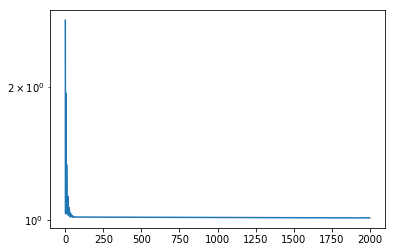

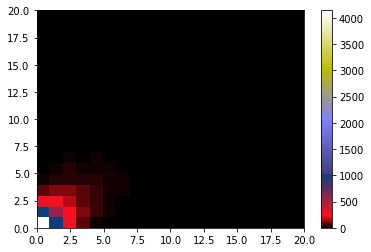

In [38]:
plot(losses)
plt.yscale('log')
plt.show()
hist2d(pred[:,0],sy,20,range=[[0,20],[0,20]],cmap='gist_stern');
plt.colorbar()
plt.show()

In [45]:
%%bash
ls modules/
# rm -r ./modules/densemodule


densemodule
fwdmodel


In [46]:
# module.export('./modules/densemodule', sess)


Ok, fair enough

In [47]:
# Now, let's see what happens if we try to maximize p(y | x) with respect to x 


Ok, so there is a little bit of code restructuring to do, but the idea here is to see if when we do gradient descent over x, we end up far away from a credible input x value, by that I mean, is $\hat{x}$ within the posterior on x for y=4

# Reconstruct here

In [72]:

def dorecon(yy, modname, useprior=True):
    tf.reset_default_graph()
    module = hub.Module(modname, trainable=False)

    xrecon = tf.get_variable('xrecon', shape=(yy.shape[0], 2), 
                             initializer=tf.random_normal_initializer(mean=(0, 0)), trainable=True)

    loglik = -module({'features':xrecon, 'labels':yy}, as_dict=True)['loglikelihood']
    prior = tf.square(xrecon)
    prior = tf.multiply(prior, stddevs**-2)
    prior = tf.reduce_sum(prior, axis=-1, keepdims=True)
    if useprior: loss = tf.add(loglik, prior)
    else: loss = loglik
#   
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
    opt_op = optimizer.minimize(loss, var_list=[xrecon])

    niter = 5000

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        xinit = sess.run(xrecon)
        losses = []
        for it in range(niter+1):
            _, l = sess.run([opt_op, loss])
            losses.append(l)
        xfin = sess.run(xrecon)
        
    return xfin, losses

In [96]:
tf.reset_default_graph()
modname = './modules/densemodule/'
xfins = []
for i in range(4):
    ii = 2*i
    yy = ii* ones((512)).astype('float32')
    recons = dorecon(yy, modname, useprior=True)
    xfin = np.squeeze(recons[0])
    xfins.append(xfin)



INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


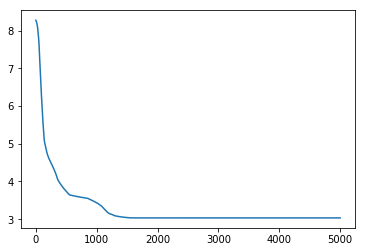

0 5577
2 901
4 259
6 123


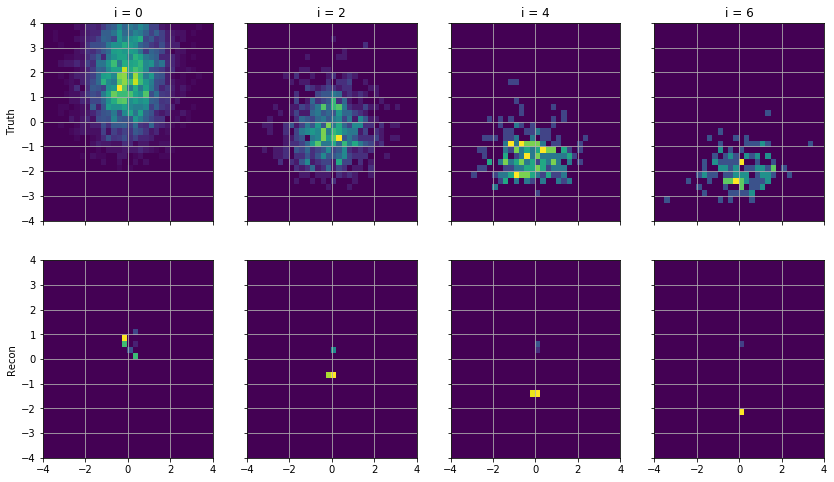

In [97]:
plt.plot(np.squeeze(np.array(recons[1])[:, 0]))
plt.show()

fig, ax = plt.subplots(2,4, figsize=(14, 8), sharex=True, sharey=True)
for i in range(4):
    ii = 2*i
    m = (sy == ii)
    print(ii, m.sum())
    ax[0, i].hist2d(sx[:,0][m], sx[:,1][m],32,range=[[-4,4],[-4,4]],normed=True)#;gca().set_aspect('equal')
    ax[1, i].hist2d(xfins[i].T[0].flatten(), xfins[i].T[1].flatten(),32,
           range=[[-4,4],[-4,4]],normed=True)#;gca().set_aspect('equal')
    ax[0, i].set_title('i = %d'%ii)
    ax[0, 0].set_ylabel('Truth')
    ax[1, 0].set_ylabel('Recon')
    
for axis in ax.flatten(): axis.grid(which='both')
    # plt.colorbar()


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


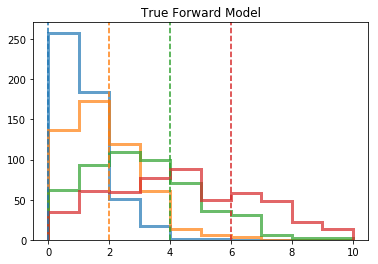

In [98]:
tf.reset_default_graph()

fwmodule = hub.Module('./modules/fwdmodel/')

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(4):
        samples = fwmodule({'input':xfins[i]}, as_dict=True)['sample']
        samples = sess.run(samples)
        plt.hist(samples, alpha=0.7, range=(0, 10), bins=10, color='C%d'%i, histtype='step', lw=3)
        plt.axvline(2*i, color='C%d'%i, ls="--")
    plt.title('True Forward Model')

In [395]:
# for i in range(3):
#     rates = np.array([np.matmul(i, AA) for i in xfins[i]]).sum(axis=1)
#     plt.hist(np.random.poisson(np.exp(rates)), alpha=0.7, range=(0, 10), bins=10, color='C%d'%i)
#     plt.axvline(2*i, color='C%d'%i)
#     plt.title('True Forward Model')

# Custom dense layer

In [60]:
import sys
sys.path.append('./utils/')
import tfops, layers
from layers import SpecDenseLayer

In [460]:
# class SpecDenseLayer(tf.keras.layers.Layer):
#     def __init__(self, num_outputs, activation=None):
#         super(SpecDenseLayer, self).__init__()
#         self.num_outputs = num_outputs
#         if activation is None: activation = tf.identity
#         self.activation = activation
# #         print(self.name)
    
#     def build(self, input_shape):
#         self.kernel = self.add_variable("kernel", 
#                                     shape=[int(input_shape[-1]), 
#                                            self.num_outputs])
#         self.bias = self.add_variable("bias", 
#                                     shape=[self.num_outputs])
    
# #     def call(self, input):
# #         x = tf.matmul(input, self.kernel)
# #         x += self.bias
# #         x = self.activation(x)
# #         return x

#     def call(self, input):
#         with tf.variable_scope(self.name+'/kernelspecnorm') as scope:
#             if tfops.scope_has_variables(scope):
#                 scope.reuse_variables()
#             x = tf.matmul(input, tfops.spectral_normed_weight(self.kernel))
#             x += self.bias
#             x = self.activation(x)
#             return x


# tf.reset_default_graph()
# layer = SpecDenseLayer(10)
# # print(layer(tf.zeros([10, 5])))
# inp = (tf.zeros([20, 5]))
# print(inp.shape)
# print(layer(inp))
# print(layer.trainable_variables)


(20, 5)
Tensor("spec_dense_layer/spec_dense_layer/kernelspecnorm/Identity:0", shape=(20, 10), dtype=float32)
[<tf.Variable 'spec_dense_layer/kernel:0' shape=(5, 10) dtype=float32>, <tf.Variable 'spec_dense_layer/bias:0' shape=(10,) dtype=float32>]


./utils/tfops.py:35: UserWarning: Setting update_collection to None will make u being updated every W execution. This maybe undesirable. Please consider using a update collection instead.
  warnings.warn('Setting update_collection to None will make u being updated every W execution. This maybe undesirable'


In [62]:
# tf.reset_default_graph()

# l1 = SpecDenseLayer(1024, activation=tf.nn.leaky_relu)
# l2 = SpecDenseLayer(512, activation=tf.nn.leaky_relu)
# l3 = SpecDenseLayer(1)

# net = l1(sx)
# # net = l2(net)
# net = l3(net)
# out_prob = tfd.Poisson(log_rate=net)
# pred = out_prob.sample()

# loss = -tf.reduce_mean(out_prob.log_prob(tf.expand_dims(sy, axis=-1)))

# optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
# train_op = optimizer.minimize(loss)

# sess = tf.Session()
# sess.run(tf.global_variables_initializer())

# losses =[]
# for i in range(2000):
#     l,_= sess.run([loss, train_op])
#     losses.append(l)
    
# plot(losses)
# plt.yscale('log')
# plt.show()

# # Try to predict the outcome
# tp = sess.run(pred)

# hist2d(tp[:,0],sy,20,range=[[0,20],[0,20]],cmap='gist_stern');
# plt.colorbar()


In [66]:
tf.reset_default_graph()


def module_fn():
    '''Define network here'''
    x = tf.placeholder(tf.float32, shape=[None, ndim], name='input')
    y = tf.placeholder(tf.float32, shape=[None], name='output')

    net = SpecDenseLayer(1024, activation=tf.nn.leaky_relu)(x)
    net = SpecDenseLayer(512, activation=tf.nn.leaky_relu)(net)
    net = SpecDenseLayer(1)(net)
#     net = tf.nn.softplus(net, name='lograte')
    out_prob = tfd.Poisson(log_rate=net, name='out_prob')
    loglik = out_prob.log_prob(tf.expand_dims(y, axis=-1))
    sample = out_prob.sample(name='prediction')
    #
    # 
    inputs = dict(input=x, label=y)
    outputs = dict(default=net, loglik=loglik, prediction=sample)
    hub.add_signature(inputs={'features':x, 'labels':y}, 
                          outputs={'sample':sample, 'loglikelihood':loglik, 'lograte':net})
    
#####                                                                                                                                                                                                                                                                                     

spec = hub.create_module_spec(module_fn)
module = hub.Module(spec, trainable=True)

xx = tf.placeholder(tf.float32, shape=[None, ndim], name='input')
lograte = module({'features':xx, 'labels':sy}, as_dict=True)['lograte']
loglik = module({'features':xx, 'labels':sy}, as_dict=True)['loglikelihood']
sample = module({'features':xx, 'labels':sy}, as_dict=True)['sample']
loss = -tf.reduce_mean(loglik)


optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train_op = optimizer.minimize(loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())
losses =[]

lrate0 = sess.run(lograte, feed_dict={xx:sx[:10]})
for i in range(2000):
    l,_= sess.run([loss, train_op], feed_dict={xx:sx})
    losses.append(l)
lrate1 = sess.run(lograte, feed_dict={xx:sx[:10]})
pred = sess.run(sample, feed_dict={xx:sx})


# module.export('./densemodule', sess)


./utils/tfops.py:35: UserWarning: Setting update_collection to None will make u being updated every W execution. This maybe undesirable. Please consider using a update collection instead.
  warnings.warn('Setting update_collection to None will make u being updated every W execution. This maybe undesirable'
./utils/tfops.py:35: UserWarning: Setting update_collection to None will make u being updated every W execution. This maybe undesirable. Please consider using a update collection instead.
  warnings.warn('Setting update_collection to None will make u being updated every W execution. This maybe undesirable'
./utils/tfops.py:35: UserWarning: Setting update_collection to None will make u being updated every W execution. This maybe undesirable. Please consider using a update collection instead.
  warnings.warn('Setting update_collection to None will make u being updated every W execution. This maybe undesirable'


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [67]:
%%bash
ls modules/
# rm -r ./modules/specdensemodule


densemodule
fwdmodel
specdensemodule


In [70]:
# module.export('./modules/specdensemodule', sess)


## recon again 

In [99]:
tf.reset_default_graph()
modname = './modules/specdensemodule/'
xfinsspec = []
for i in range(4):
    ii = 2*i
    yy = ii* ones((512)).astype('float32')
    recons = dorecon(yy, modname, useprior=True)
    xfin = np.squeeze(recons[0])
    xfinsspec.append(xfin)



INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


0 5577
2 901
4 259
6 123


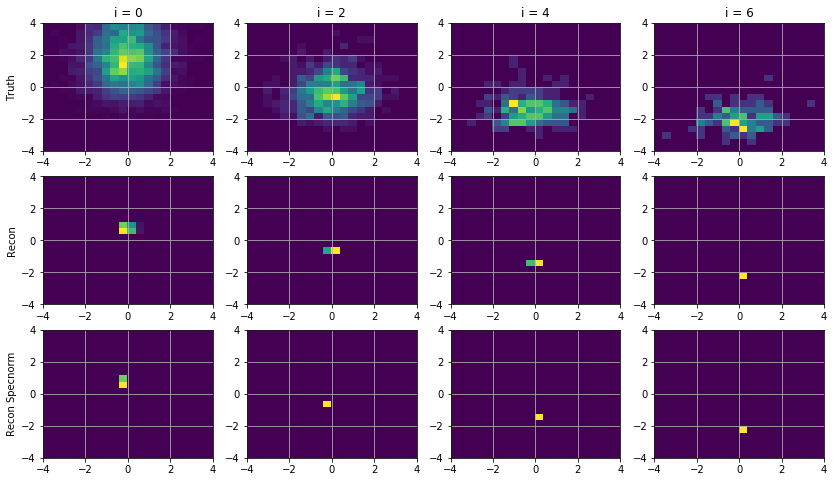

In [100]:
nbins = 20
fig, ax = plt.subplots(3,4, figsize=(14, 8), sharex=False, sharey=False)
for i in range(4):
    ii = 2*i
    m = (sy == ii)
    print(ii, m.sum())
    ax[0, i].hist2d(sx[:,0][m], sx[:,1][m],
                    nbins,range=[[-4,4],[-4,4]],normed=True)
    ax[1, i].hist2d(xfins[i].T[0].flatten(), xfinsspec[i].T[1].flatten(),
                    nbins, range=[[-4,4],[-4,4]],normed=True)
    ax[2, i].hist2d(xfinsspec[i].T[0].flatten(), xfinsspec[i].T[1].flatten(),
                    nbins, range=[[-4,4],[-4,4]],normed=True)

    ax[0, i].set_title('i = %d'%ii)
    ax[0, 0].set_ylabel('Truth')
    ax[1, 0].set_ylabel('Recon')
    ax[2, 0].set_ylabel('Recon Specnorm')
    
for axis in ax.flatten(): axis.grid(which='both')
    # plt.colorbar()


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


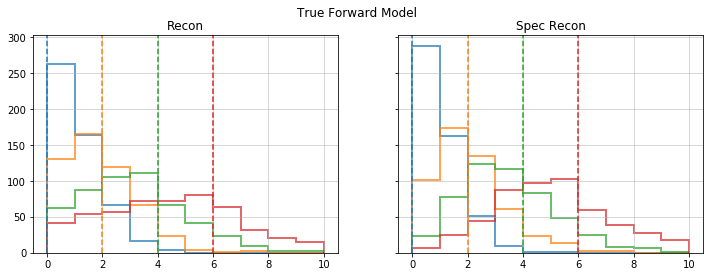

In [105]:
tf.reset_default_graph()

fwmodule = hub.Module('./modules/fwdmodel/')

fig, axar = plt.subplots(1, 2, figsize = (12, 4), sharey=True)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(4):
        samples = fwmodule({'input':xfins[i]}, as_dict=True)['sample']
        samples = sess.run(samples)
        ax = axar[0]
        ax.hist(samples, alpha=0.7, range=(0, 10), bins=10, color='C%d'%i, 
                 histtype='step', lw=2)
        ax.axvline(2*i, color='C%d'%i, ls="--")
        ax.set_title('Recon')
        
        samples = fwmodule({'input':xfinsspec[i]}, as_dict=True)['sample']
        samples = sess.run(samples)
        ax = axar[1]
        ax.hist(samples, alpha=0.7, range=(0, 10), bins=10, color='C%d'%i, 
                 histtype='step', lw=2, ls="-")
        ax.set_title('Spec Recon')
        
        ax.axvline(2*i, color='C%d'%i, ls="--")
plt.suptitle('True Forward Model')
for axis in axar: axis.grid(lw=0.5)